In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)

2.4.1


In [3]:
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
#np.set_printoptions(threshold=np.inf)
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

Processing NIH chest x-ray data

import os
import shutil  #high-level file operations like copying a file
import random

seed = 1
random.seed(seed)

train = "data/balanced_set_normal_Pneumonia/train/"
test = "data/balanced_set_normal_Pneumonia/test/"
validation = "data/balanced_set_normal_Pneumonia/validation/"

os.makedirs(train + "normal/")
os.makedirs(train + "pneumonia/")
os.makedirs(test + "normal/")
os.makedirs(test + "pneumonia/")
os.makedirs(validation + "normal/")
os.makedirs(validation + "pneumonia/")

test_examples = train_examples = validation_examples = 0


for i in range(1, 13):
    directory = "data/images_" + str(i) + "/"
    print(directory)

    for line in open("data/Data_Entry_2017_v2020_normal_Pneumonia_only.csv").readlines()[1:]:
        split_line = line.split(",")
        img_file = split_line[0]
        normal_pneumonia = split_line[1]

        #if os.path.isfile("data/images_001/" + img_file):
        if os.path.isfile(directory + img_file):
            random_num = random.random()

            if random_num <0.8:
                location = train
                train_examples += 1
            elif random_num <0.9:
                location = validation
                validation_examples += 1
            else: 
                location = test
                test_examples += 1
            #print(normal_pneumonia)
            if normal_pneumonia == "Pneumonia":
            #if 'Pneumonia' in normal_pneumonia:
                shutil.copy(
                    directory + img_file,
                    location + "pneumonia/" + img_file,
                )
            #elif 'Pneumonia' not in normal_pneumonia:
            #    print('not in')
            elif normal_pneumonia == "No Finding":
                shutil.copy(
                    directory + img_file,
                    location + "normal/" + img_file,
                )

print(f"Number of training examples {train_examples}")
print(f"Number of test examples {test_examples}")
print(f"Number of validation examples {validation_examples}")
    

In [5]:
train = "data/balanced_set_normal_Pneumonia/train/"
test = "data/balanced_set_normal_Pneumonia/test/"
validation = "data/balanced_set_normal_Pneumonia/validation/"


reduce number of samples for "normal" by randomly selecet small number of samples

dirpath = "data/validation/normal/"
destDirectory = "data/balanced_set/validation/normal/"
filenames = random.sample(os.listdir(dirpath), 150)
for fname in filenames:
    srcpath = os.path.join(dirpath, fname)
    shutil.copy(srcpath, destDirectory)

import os
import shutil  #high-level file operations like copying a file
import random
source_dir = train + "normal/"
dest_dir = train + "normal_downsampling/"
os.makedirs(dest_dir)
filenames = random.sample(os.listdir(source_dir), 2000)
for fname in filenames:
    srcpath = os.path.join(source_dir, fname)
    shutil.copy(srcpath, dest_dir)

use data augmentation for train data only to prevent overfitting

In [6]:
train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range = 18,
    zoom_range = (0.92, 0.92),
    width_shift_range = 0.1, 
    height_shift_range = 0.1,
    horizontal_flip = False,
    #vertical_flip = True,
    data_format = "channels_last",
    dtype = tf.float32,
)

validation_datagen = ImageDataGenerator(rescale=1.0/255, dtype=tf.float32)
test_datagen = ImageDataGenerator(rescale=1.0/255, dtype=tf.float32)


In [7]:
img_height = 224
img_width = 224
batch_size = 32


In [8]:
train_gen = train_datagen.flow_from_directory(
    train,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = "binary",
    shuffle = True,
    seed = 123,
)
validation_gen = validation_datagen.flow_from_directory(
    validation,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = "binary",
    shuffle = True,
    seed = 123,
)
test_gen = test_datagen.flow_from_directory(
    test,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = "binary",
    shuffle = False,
    seed = 123,
)

Found 2512 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 209 images belonging to 2 classes.


In [9]:
train_examples = train_gen.samples 
validation_examples = validation_gen.samples 
test_examples = test_gen.samples 

print(f"Number of training examples {train_examples}") 
print(f"Number of validation examples {validation_examples}")
print(f"Number of test examples {test_examples}") 

train_image_normal_count = len(os.listdir('data/balanced_set_normal_Pneumonia/train/normal'))
train_image_pneumonia_count = len(os.listdir('data/balanced_set_normal_Pneumonia/train/pneumonia'))
validation_image_normal_count = len(os.listdir('data/balanced_set_normal_Pneumonia/validation/normal'))
validation_image_pneumonia_count = len(os.listdir('data/balanced_set_normal_Pneumonia/validation/pneumonia'))
test_image_normal_count = len(os.listdir('data/balanced_set_normal_Pneumonia/test/normal'))
test_image_pneumonia_count = len(os.listdir('data/balanced_set_normal_Pneumonia/test/pneumonia'))

print(f"train_image_normal_count {train_image_normal_count}")
print(f"train_image_pneumonia_count {train_image_pneumonia_count}")

ratio = train_image_pneumonia_count / train_image_normal_count
print(ratio)
initial_bias = np.log(train_image_pneumonia_count/train_image_normal_count)
print(initial_bias)

Number of training examples 2512
Number of validation examples 237
Number of test examples 209
train_image_normal_count 2000
train_image_pneumonia_count 512
0.256
-1.3625778345025745


In [10]:
# def plotImages(imgs, labels):
#     plt.figure(figsize=(12,12))
#     plt.tight_layout()

#     for n in range(batch_size):
#         ax = plt.subplot(6,6,n+1)
#         plt.imshow(imgs[n])
#         if labels[n]:
#             plt.title("PNEUMONIA")
#         else:
#             plt.title("NORMAL")
#         plt.axis("off")
#     plt.show()

In [11]:
# imgs, labels = next(train_gen)

In [12]:
# print(f"Train labels: {labels}")
# plotImages(imgs, labels)

In [13]:
# imgs, labels = next(test_gen)
# print(f"Test labels: {labels}")
# plotImages(imgs, labels)

In [14]:
import math

test_labels = np.array([])
num_batches = 0

for _, y in test_gen:
    test_labels = np.append(test_labels, y)
    num_batches +=1
    if num_batches == math.ceil(test_examples / batch_size):
        break

In [15]:
import sklearn.metrics as metrics

def plot_roc(labels, predictions):
    fp, tp, thresholds = roc_curve(labels, predictions)

    roc_auc = metrics.auc(fp, tp)
    
    plt.plot(fp, tp, 'm', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.xlabel("False Positives [%]")
    plt.ylabel("True Positives [%]")
    plt.show()

Loading final 3 models and performing majority vote 

In [29]:
loaded_model_DenseNet201 = tf.keras.models.load_model('./MyModel_DenseNet201')

In [25]:
#loaded_model_ResNet152V2 = tf.keras.models.load_model('./MyModel_ResNet152V2_auc69')

In [17]:
#loaded_model_NASNet_mobile_hub = tf.keras.models.load_model('./MyModel_NASNet_mobile_hub_auc75')

In [82]:
x1_train = loaded_model_ResNet152V2.predict(train_gen)
x2_train = loaded_model_NASNet_mobile_hub.predict(train_gen)
x3_train = loaded_model_DenseNet201.predict(train_gen)

In [83]:
x1_test = loaded_model_ResNet152V2.predict(test_gen)
x2_test = loaded_model_NASNet_mobile_hub.predict(test_gen)
x3_test = loaded_model_DenseNet201.predict(test_gen)


In [84]:
x_train = np.vstack((x1_train[:, 0], x2_train[:, 0], x3_train[:, 0])).T
print(x_train)

[[2.8141439e-03 5.6739861e-01 9.4507224e-05]
 [3.4177601e-01 6.9191039e-01 8.2349777e-04]
 [9.2414021e-04 1.8933713e-03 1.1549759e-01]
 ...
 [7.3513514e-01 4.9699247e-03 3.1793118e-04]
 [1.4951527e-03 7.1856803e-01 1.0217522e-05]
 [9.7487259e-01 2.0323122e-01 6.1640026e-06]]


In [90]:
x_test =np.vstack((x1_test[:, 0], x2_test[:, 0], x3_test[:, 0])).T
print(x_test)

[[2.88477540e-03 1.39932930e-02 1.92940235e-04]
 [9.06479359e-03 1.33156478e-02 1.43764164e-05]
 [3.11377525e-01 9.75687206e-02 1.45502936e-05]
 [4.72566485e-03 3.29111814e-02 4.78663969e-05]
 [1.21164322e-03 1.34000331e-01 5.37679672e-01]
 [8.08507204e-04 1.53325498e-02 1.04079163e-06]
 [1.90222418e-05 1.75596774e-02 2.83947587e-03]
 [1.46445632e-03 4.41400915e-01 5.77655435e-03]
 [4.48018312e-04 4.18008566e-02 4.45733895e-05]
 [5.96573532e-01 4.17248607e-01 3.40077639e-01]
 [1.12071633e-03 1.89505816e-02 5.34883142e-03]
 [5.62369823e-03 3.13441455e-02 8.32512975e-03]
 [1.42592192e-02 1.81976259e-02 2.01880932e-04]
 [4.24958706e-01 1.05035305e-03 1.02500021e-02]
 [2.94208527e-04 2.46231705e-01 1.12168573e-06]
 [8.40611160e-02 1.61651969e-02 2.89762020e-03]
 [6.04325652e-01 3.69653523e-01 1.63638294e-02]
 [2.01071707e-05 3.62601876e-03 3.40145533e-07]
 [6.09099865e-04 1.44893378e-01 6.58720732e-04]
 [9.52117205e-01 6.45760179e-01 3.41571445e-06]
 [6.16631078e-05 1.18548572e-02 8.824862

In [85]:
y_train = train_gen.classes
y_train = y_train.reshape(train_examples,1)
print(y_train)

[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


In [87]:
y_test = test_gen.classes
y_test = y_test.reshape(test_examples,1)
print(y_test)

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]


In [466]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(3,)),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])
adam=keras.optimizers.Adam(lr = 0.0005)
model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [467]:
model.fit(x_train, y_train, epochs=3, batch_size=32)
#classifications = model.predict(x_test)
#print(classifications)
#test_loss, test_acc = model.evaluate(x_test, y_test)
#print(test_loss, test_acc)

Epoch 1/3
96/96 [==============================] - 2s 3ms/step - loss: 0.8307 - accuracy: 0.6324
Epoch 2/3
96/96 [==============================] - 0s 3ms/step - loss: 0.7871 - accuracy: 0.6877
Epoch 3/3
96/96 [==============================] - 0s 3ms/step - loss: 0.7636 - accuracy: 0.6955


In [468]:
prediction_probs = model.predict(x_test)
prediction_classes = (prediction_probs > 0.5).astype("int32")

In [469]:
# reduce to 1d array
# model 1:
y_probs = prediction_probs[:, 0]
y_classes = prediction_classes[:, 0]
test_labels = test_gen.classes


Accuracy: 0.736677
Precision: 0.112676
Recall: 0.275862
F1_score: 0.160000
Cohens_kappa: 0.035491
ROC_AUC_score: 0.448157
Confusion_matrix:
                    TrueP FalseN
                    FalseP TrueN
[[  8  21]
 [ 63 227]]


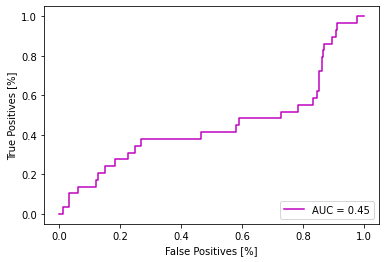

In [470]:
accuracy = accuracy_score(test_labels, y_classes)
print('Accuracy: %f' % accuracy)
precision = precision_score(test_labels, y_classes)
print('Precision: %f' % precision)
recall = recall_score(test_labels, y_classes)
print('Recall: %f' % recall)
f1 = f1_score(test_labels, y_classes)
print('F1_score: %f' % f1)
kappa = cohen_kappa_score(test_labels, y_classes)
print('Cohens_kappa: %f' % kappa)
auc_score = roc_auc_score(test_labels, y_probs)
print('ROC_AUC_score: %f' % auc_score)
print('Confusion_matrix:')
print('                    TrueP FalseN')
print('                    FalseP TrueN')
matrix = confusion_matrix(test_labels, y_classes, labels=[1, 0])
print(matrix)
plot_roc(test_labels, prediction_probs)


In [351]:
# #print(test_labels)
# print(prediction_classes)
# print(prediction_probs)